In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 라이브러리 import

In [2]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torchvision

## Device 설정

In [3]:
# device 설정
# 만약 cuda 설정이 되어있지 않다면 cpu를 사용한다
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

## 데이터 Load 및 Preprocessing

In [53]:
batch_size = 100

# 방대한 데이터 이미지를 한번에 변형 (데이터 전처리)
# Resize 한 이유 : data를 바꾸니 input tensor의 크기가 작아서 RuntimeError가 발생했었다
transform = transforms.Compose(
    [transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))] # 각 channel에 맞춰서 normalize 진행 (FasionMNIST에서는 gray scale만 normalize함)
)

fashionMNIST_train = datasets.FashionMNIST(root='/content/',train=True,transform=transform,target_transform=None,download=True)
fashionMNIST_test = datasets.FashionMNIST(root="/content/", train=False, transform=transform, target_transform=None, download=True)

# fashionMNIST_train, fashionMNIST_test 데이터를 미리 설정한 batch_size(100) 형태로 만들어 train_loader, test_loader 변수에 넣는다
train_loader = DataLoader(fashionMNIST_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(fashionMNIST_test, batch_size=batch_size)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### 데이터 시각화

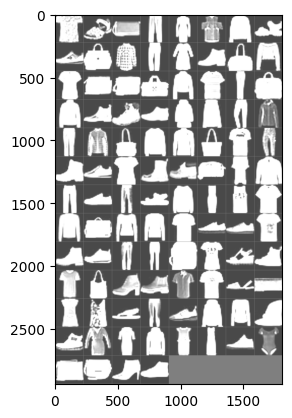

Shirt Sandal   Bag Trouser Dress Shirt  Coat Sandal Sneaker   Bag Shirt Trouser Dress Ankle boot   Bag Pullover T-shirt/top   Bag   Bag   Bag  Coat T-shirt/top Trouser   Bag  Coat Ankle boot Ankle boot Ankle boot  Coat Pullover Trouser  Coat Trouser  Coat   Bag Pullover Pullover   Bag T-shirt/top Trouser Ankle boot Sneaker Shirt Ankle boot Ankle boot   Bag Dress Pullover Trouser Sneaker Trouser Sandal Pullover Dress T-shirt/top T-shirt/top Pullover   Bag Pullover Pullover T-shirt/top Sneaker Sneaker T-shirt/top Ankle boot Ankle boot Trouser Trouser   Bag T-shirt/top Sandal Ankle boot T-shirt/top   Bag Ankle boot Ankle boot Shirt T-shirt/top Sandal   Bag Dress Shirt Sandal Trouser Sneaker  Coat Pullover Ankle boot Sneaker Dress Dress Pullover Dress Dress Sneaker T-shirt/top   Bag   Bag Ankle boot Sneaker


In [54]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수
def imshow(img):
    # unnormalize (시각화를 위해서)
    img = img / 2 + 0.5 #0~1 사이 형태에서 벗어나게 하기 위함??

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #이미지 차원 조절
    plt.show()

# 학습용 이미지를 무작위로 가져오기
images, labels = next(iter(train_loader))

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

# 정답(label) 출력
print(' '.join('%5s' % class_names[labels[j]] for j in range(batch_size)))

Trouser


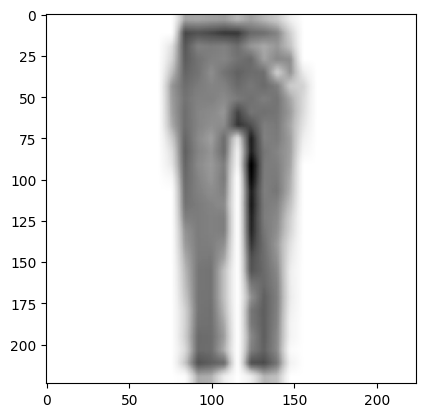

In [55]:
def matplotlib_imshow(img):
    img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(npimg, cmap="Greys")

# get some random training images
images, labels = next(iter(train_loader))

# creat grid of images
img_grid = torchvision.utils.make_grid(images[0])

# show images & labels
matplotlib_imshow(img_grid)
print(class_names[labels[0]])

# VGG16 Architecture
![이미지](https://miro.medium.com/v2/resize:fit:857/1*AqqArOvacibWqeulyP_-8Q.png)

합성곱 연산 2번(채널 64) ->
합성곱 연산 2번(채널 128) ->
합성곱 연산 3번(채널 256) ->
합성곱 연산 3번(채널 512) ->
합성곱 연산 3번(채널 512) ->
FC Layer 3번

- FC Layer 목록
  - FC Layer 4096
  - FC Layer 4096
  - FC Layer 1000 (카테고리 개수)

## 모델 아키텍처를 나누지 않은 이유
### FasionMNIST가 흑백 데이터세트가 보니까 RuntimeError가 발생했었다.
### 따라서 그냥 하나하나 계산하면서 길게 작성했다

In [71]:
import torch.nn as nn
import torch.nn.functional as F

class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        # 첫 번째 convolutional 레이어 (입력 채널: 1, 출력 채널: 64, 필터 크기: 3x3, 패딩: 1)
        self.conv1_1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(25088, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.5)
        x = self.fc3(x)
        return x

# REFERENCE : https://www.kaggle.com/code/ellaleee/vgg16-fashion-mnist

## hyperparameter 설정 및 모델 선언

In [65]:
import torch.optim as optim

learning_rate = 1e-4

model = VGG16().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate)

## Training
### 데이터 변경 시 아래와 같은 error 발생
- RuntimeError: Given groups=1, weight of size [64, 3, 3, 3], expected input[100, 1, 28, 28] to have 3 channels, but got 1 channels instead

### OutOfMemoryError 발생
- 메모리 부족 문제라 colab 환경으로 옮겨서 진행했음에도 불구하고 계속 메모리 부족 문제가 발생했다. (모델이 너무 복잡한가 왜 메모리 초과가 나는지 모르겠다;;)

In [72]:
for epochs in range(10): #I decided to train the model for 50 epochs
    loss_ep = 0

    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)
        ## Forward Pass
        optimizer.zero_grad()
        scores = model(data)
        loss = criterion(scores,targets)
        loss.backward()
        optimizer.step()
        loss_ep += loss.item()
    print(f"Epoch {epochs+1} ] Loss : {loss_ep/len(train_loader):.6f}")

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.20 GiB. GPU 0 has a total capacity of 14.75 GiB of which 145.06 MiB is free. Process 8348 has 14.60 GiB memory in use. Of the allocated memory 13.67 GiB is allocated by PyTorch, and 832.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## 모델 평가 시각화 및 정확도 출력

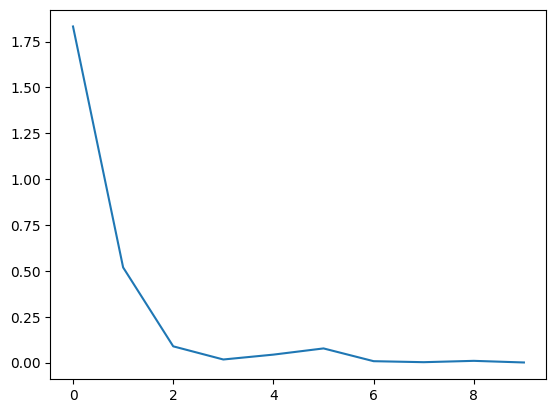

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_arr)
plt.show()

In [ ]:
# 모델 평가에 사용될 변수 선언 및 모델 평가하기
correct = 0
total = 0
model.eval()

# torch.no_grad() : 기울기(gradient)를 계산하지 않는다.
with torch.no_grad():
    for i, [image, label] in enumerate(test_loader):
        x = image.to(device)
        y = label.to(device)

        output = model.forward(x) # forward() : 모델이 학습 데이터를 입력 받아서 forward 연산 수행 / forward를 호출하여 입력 데이터를 모델에 전달
        _, output_index = torch.max(output, 1)  # 모델의 출력을 기반으로 예측 수행. torch.max 함수를 사용하여 출력 텐서 output에서 가장 큰 값의 인덱스를 찾는다.
                                                # torch.max(output, 1) : 각 행에서 (최대값, 해당 인덱스) 반환
        # 모델 평가에서 선언한 변수들의 값 계산 ()
        total += label.size(0)
        correct += (output_index == y).sum().float()

    # 모델 정확도 출력
    print("Accuracy of Test Data: {}%".format(100 * correct / total))

Accuracy of Test Data: 81.48999786376953%
